In [6]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm
import time

NGIDS_path = './dataset/NGIDS_host_log_1-99.csv'

device = torch.device('cuda') # GPU 사용
batch_size = 256
slide_window_size = 100
learning_rate = 0.001
max_epochs = 150
hidden_size = 8
hhidden_size = 6
num_layers = 1
early_stop = 20

In [7]:
NGIDS = pd.read_csv(NGIDS_path)
        
dropna_NGIDS = NGIDS.dropna(subset=['path', 'sys_call', 'label'])

path = np.array(dropna_NGIDS['path'].to_list())
syscall = np.array(dropna_NGIDS['sys_call'].to_list())
label = np.array(dropna_NGIDS['label'].to_list())

l = int(len(path) / slide_window_size)

path = path[:l * slide_window_size].reshape(l, slide_window_size)
syscall = syscall[:l * slide_window_size].reshape(l, slide_window_size)
label = label[:l * slide_window_size].reshape(l, slide_window_size)

label = np.max(label, axis = 1)
#label = label[:, -1]

positive_path = []
positive_syscall = []

negative_path = []
negative_syscall = []

for i in range(l) :
    if label[i] == 1 :
        negative_path.append(path[i])
        negative_syscall.append(syscall[i])
    else :
        positive_path.append(path[i])
        positive_syscall.append(syscall[i])


positive_len = len(positive_path)
negative_len = len(negative_path)

print("positive : ", positive_len)
print("negative : ", negative_len)


positive :  882954
negative :  17588


In [10]:
X_train, X_vali, y_train, y_vali = train_test_split(
    list(zip(positive_path[:positive_len - negative_len - 1], positive_syscall[:positive_len - negative_len - 1]))
    , [0 for i in range(positive_len - negative_len - 1)], test_size=0.2, random_state=42)

X_test = list(zip(positive_path[positive_len - negative_len : positive_len] + negative_path, 
                positive_syscall[positive_len - negative_len : positive_len] + negative_syscall))
y_test = [ 0 for i in range(negative_len)] + [ 1 for i in range(negative_len)]

In [11]:
print(len(X_train), len(y_train))
print(len(X_vali), len(y_vali))
print(len(X_test), len(y_test))

692292 692292
173073 173073
35176 35176


In [12]:
import gensim

def save_path(vector_size, window, data_name="NGIDS_path_w2v"):
    return "./dataset/PathSystem/" + f"vectorsize{vector_size}_window{window}_" + data_name

def save_sys(vector_size, window, data_name = "NGIDS_vector"):
    return "./dataset/PathSystem/" + f"vectorsize{vector_size}_window{window}_" + data_name


vector_size = 10
window = 3
input_size = vector_size

NGIDS_sys_model = gensim.models.Word2Vec.load(save_sys(vector_size, window))
NGIDS_path_model = gensim.models.Word2Vec.load(save_path(vector_size, window, "NGIDS_vector"))

In [ ]:
p2i = NGIDS_path_model.wv.key_to_index
s2i = NGIDS_sys_model.wv.key_to_index

NGIDS_dataset = NGIDS_Dataset(X_train, y_train, p2i, s2i, slide_window_size)
train_loader = DataLoader(NGIDS_dataset, batch_size=batch_size, shuffle = True)

NGIDS_valiset = NGIDS_Dataset(X_vali, y_vali, p2i, s2i, slide_window_size)
vali_loader = DataLoader(NGIDS_valiset, batch_size=batch_size, shuffle = True)

NGIDS_testset = NGIDS_Dataset(X_test, y_test, p2i, s2i, slide_window_size)


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, hhidden_size, num_layers, dropout_p=0.5):
        super(Encoder, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_p)
        self.gru2 = nn.GRU(hidden_size, hhidden_size, batch_first=True)
        
    def forward(self, batch):
        batch, _ = self.gru1(batch)
        batch = self.dropout(batch)
        outputs, hidden = self.gru2(batch)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, hhidden_size, num_layers, dropout_p=0.5):
        super(Decoder, self).__init__()
        self.gru1 = nn.GRU(hhidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_p)
        self.gru2 = nn.GRU(hidden_size, input_size, batch_first=True)

    def forward(self, batch):
        batch, _ = self.gru1(batch)
        batch = self.dropout(batch)
        output, hidden = self.gru2(batch)
        return output, hidden

In [ ]:
class GRU_AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, hhidden_size, num_layers, path_vecs, sys_vecs):
        super(GRU_AutoEncoder, self).__init__()
        
        self.path_emb = nn.Embedding.from_pretrained(torch.tensor(path_vecs, dtype=torch.float).cuda(), freeze=True)
        self.sys_emb = nn.Embedding.from_pretrained(torch.tensor(sys_vecs, dtype=torch.float).cuda(), freeze=True)

        self.encoder = Encoder(input_size=input_size, hidden_size=hidden_size, hhidden_size=hhidden_size, num_layers=num_layers)
        self.reconstruct_decoder = Decoder(input_size=input_size, hidden_size=hidden_size, hhidden_size=hhidden_size, num_layers=num_layers)
        self.input_size = input_size

        self.criterion = nn.MSELoss()

    def forward(self, batch):
        batch, _  = batch

        batch = batch.to(device)

        batch_size, sequence_length, _ = batch.size()
        vector_size = self.input_size
        
        path_batch = self.path_emb(batch[:,:,0])
        sys_batch = self.sys_emb(batch[:,:,1])

        batch = path_batch + sys_batch
        batch = batch.reshape(batch_size, sequence_length, vector_size)
        
        outputs, encoder_hidden = self.encoder(batch)
        outputs, decoder_hidden = self.reconstruct_decoder(outputs)
        
        reconstruct_loss = self.criterion(outputs, batch)

        batch = batch.to("cpu")
        torch.cuda.empty_cache()

        return outputs, reconstruct_loss

In [ ]:
def run(model, train_loader):

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs = range(max_epochs)
    
    loss_list = []
    min_loss = 1
    count = 0
    
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()

        for i, batch_data in enumerate(train_loader):

            _, reconstruct_loss = model(batch_data)

            loss = reconstruct_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()        
        epoch_loss = 0

        with torch.no_grad() :
            for i, batch_data in enumerate(vali_loader):
                _, reconstruct_loss = model(batch_data)
                epoch_loss = epoch_loss + reconstruct_loss
            
            epoch_loss = epoch_loss / len(vali_loader)
            loss_list.append(epoch_loss)

            print(f"[{epoch + 1}/{max_epochs}] loss : {epoch_loss}  -- " + 
                    f"{time.strftime('%H:%M:%S', time.localtime(time.time()))}")

        if min_loss > epoch_loss :
            min_loss = epoch_loss
            save_model = model
            count = 0
        else :
            count = count + 1

        #torch.save(model, f"GRU_Positive_training_Auto_encoder_epoch{epoch}.model")

        if count >= early_stop :
            break
            
    return save_model

In [12]:
model = GRU_AutoEncoder(input_size, hidden_size, num_layers, hhidden_size, NGIDS_path_model.wv.vectors, NGIDS_sys_model.wv.vectors)
model.to(device)

model = run(model, train_loader)

torch.save(model, "positive_trainingAutoEncoder.model")

print("learning finished")

[1/150] loss : 0.2257036566734314  -- 15:10:19
[2/150] loss : 0.22168932855129242  -- 15:10:58
[3/150] loss : 0.220005065202713  -- 15:11:38
[4/150] loss : 0.21732881665229797  -- 15:12:18
[5/150] loss : 0.2165941745042801  -- 15:12:58
[6/150] loss : 0.216220423579216  -- 15:13:38
[7/150] loss : 0.2159835547208786  -- 15:14:18
[8/150] loss : 0.2157013714313507  -- 15:14:58
[9/150] loss : 0.21545495092868805  -- 15:15:38
[10/150] loss : 0.21528199315071106  -- 15:16:18
[11/150] loss : 0.21521101891994476  -- 15:16:59
[12/150] loss : 0.215177521109581  -- 15:17:39
[13/150] loss : 0.21505936980247498  -- 15:18:19
[14/150] loss : 0.21498778462409973  -- 15:19:00
[15/150] loss : 0.21482466161251068  -- 15:19:40
[16/150] loss : 0.21485555171966553  -- 15:20:21
[17/150] loss : 0.21463866531848907  -- 15:21:01
[18/150] loss : 0.21473044157028198  -- 15:21:41
[19/150] loss : 0.2147301733493805  -- 15:22:22
[20/150] loss : 0.21464236080646515  -- 15:23:02
[21/150] loss : 0.21438612043857574  -- 

In [ ]:
from sklearn.ensemble import IsolationForest

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
def print_result(isfo, X_test, y_test):
    
    NGIDS_testset = NGIDS_Dataset(X_test, y_test, p2i, s2i, slide_window_size)
    test_loader = DataLoader(NGIDS_testset, batch_size=len(NGIDS_testset), shuffle = True)
    
    tmp = iter(test_loader)
    data = tmp.next()
    _, label = data
    
    output, _ = model(data)
    output = output.detach().cpu().numpy()

    y_pred = isfo.predict(output[:, -1, :])
    y_score_sample = isfo.score_samples(output[:, -1, :])

    for idx, j in enumerate(y_pred):
        if j == -1 :
            y_pred[idx] = 1
        else :
            y_pred[idx] = 0
    

    print("accuracy score :", accuracy_score(label, y_pred))
    print("recall score :", recall_score(label, y_pred))
    print("precision score :", precision_score(label, y_pred))
    print("roc_auc :", roc_auc_score(label, -y_score_sample))

In [ ]:
def ISFO_result(model, n_estimators = 100, max_samples="auto", contamination = 'auto', max_features = 1.0):
    isfo = IsolationForest()

    model.eval()

    train_loader = DataLoader(NGIDS_dataset, batch_size=batch_size, shuffle = True)
    train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True, desc="training")

    for i, batch in train_iterator :
        
        output, _ = model(batch)
        output = output.detach().cpu().numpy()
        isfo.fit(output[:, -1, :])
    
    return isfo


In [ ]:
model = torch.load("positive_trainingAutoEncoder.model")

isfo = IsolationForest(n_estimators=100)

model.eval()

train_loader = DataLoader(NGIDS_dataset, batch_size=batch_size, shuffle = True)
train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True, desc="training")

for i, batch in train_iterator :
    
    output, _ = model(batch)
    output = output.detach().cpu().numpy()
    isfo.fit(output[:, -1, :])

accuracy score : 0.6217591539686149
recall score : 0.37275415055719807
precision score : 0.7425529505040208
roc_auc : 0.7193848158406431


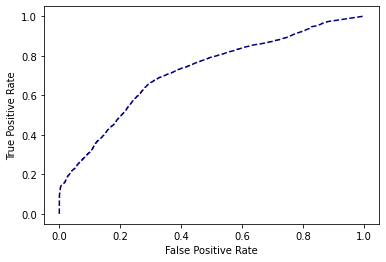

In [17]:
NGIDS_testset = NGIDS_Dataset(X_test, y_test, p2i, s2i, slide_window_size)
test_loader = DataLoader(NGIDS_testset, batch_size=len(NGIDS_testset), shuffle = True)

tmp = iter(test_loader)
data = tmp.next()
_, label = data

output, _ = model(data)
output = output.detach().cpu().numpy()

y_pred = isfo.predict(output[:, -1, :])
y_score_sample = isfo.score_samples(output[:, -1, :])

for idx, j in enumerate(y_pred):
    if j == -1 :
        y_pred[idx] = 1
    else :
        y_pred[idx] = 0

fpr, tpr, thresholds = roc_curve(label, -y_score_sample)

print("accuracy score :", accuracy_score(label, y_pred))
print("recall score :", recall_score(label, y_pred))
print("precision score :", precision_score(label, y_pred))
print("roc_auc :", roc_auc_score(label, -y_score_sample))

plt.plot(fpr, tpr, color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()